This notebook is meant to be an introduction to the stft which will be used in this project to extract features from music files. The stft is short for the Short Time Fourier Transform and creates spectograms for content whose frequencies vary throughout time (music being a perfect example). There are three tunable parameters: the size of the window, the amount of overlap between successive windows, and the size of the time windows with different frequencies. 

The size of the window has implication on the time precision and frequency resolution. Smaller windows allow for greater time precision, allowing for better observation amongst the transitions between different frequency content, but much lower frequency resolution. Frequency resolution refers to the size of the bins that frequency content gets placed into in a window. Choosing smaller windows is known as wideband and longer windows is known as narrowband. More details are shown in this image:

![NarrowbandVsWideband](./references/WidebandvsNarrowband.png)

This first example shows the results of using narrowband with a length of 20 samples per window:

![Narrowband](./references/NarrowBandSpectogram.png)

This next example shows the results of using wideband with a length of 10 samples per window:

![Wideband](./references/WideBandSpectogram.png)

Note that the terms narrowband and wideband are slighly objective, and I used them loosely to compare the two examples above. For further explanation, watch the following [video](https://www.youtube.com/watch?v=g1_wcbGUcDY).

The following is an example that generates an example of the dial buttons on a phone. The example is courteous of the video linked before, and the code is from the following [blog post](https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html). 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython.display import Audio

In [4]:
def get_signal_Hz(Hz,sample_rate,length_ts_sec):
    ## 1 sec length time series with sampling rate 
    ts1sec = list(np.linspace(0,np.pi*2*Hz,sample_rate))
    ## 1 sec length time series with sampling rate 
    # multiplying a list by a constant appends constant copies to the list itself
    ts = ts1sec*length_ts_sec
    return(list(np.sin(ts)))

In [5]:
sample_rate   = 4000
length_ts_sec = 3
## --------------------------------- ##
## 3 seconds of "digit 1" sound
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1209Hz.
## --------------------------------- ##
ts1  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts1 += np.array(get_signal_Hz(1209,sample_rate,length_ts_sec))
ts1  = list(ts1)

## -------------------- ##
## 2 seconds of silence
## -------------------- ##
ts_silence = [0]*sample_rate*1

## --------------------------------- ##
## 3 seconds of "digit 2" sounds 
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1336Hz.
## --------------------------------- ##
ts2  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts2 += np.array(get_signal_Hz(1336,sample_rate,length_ts_sec))
ts2  = list(ts2)

## -------------------- ##
## Add up to 7 seconds
## ------------------- ##
# concatenates the lists, doesn't sum their values like a numpy array
ts = ts1 + ts_silence  + ts2

In [6]:
# for i in range(100):
#     print(ts[i])

lin_test = list(np.linspace(0,np.pi*2*697,sample_rate))
for i in range(10):
    print(lin_test[i])

0.0
1.0951188194809132
2.1902376389618263
3.2853564584427395
4.380475277923653
5.475594097404565
6.570712916885479
7.665831736366393
8.760950555847305
9.856069375328218


In [6]:
Audio(ts, rate=sample_rate)

The total time series length = 7.0 sec (N points = 28000) 


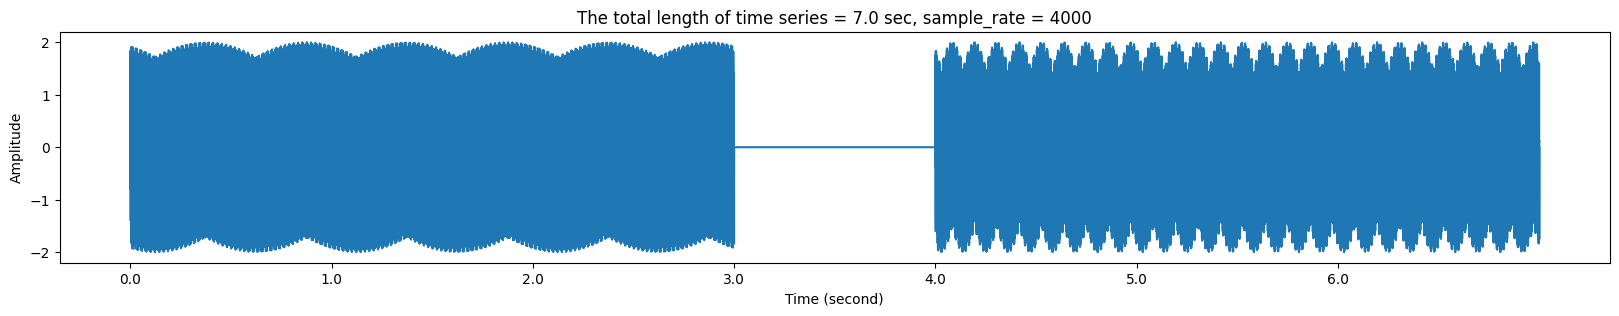

In [7]:
total_ts_sec = len(ts)/sample_rate
print("The total time series length = {} sec (N points = {}) ".format(total_ts_sec, len(ts)))
plt.figure(figsize=(20,3))
plt.plot(ts)
plt.xticks(np.arange(0,len(ts),sample_rate),
           np.arange(0,len(ts)/sample_rate,1))
plt.ylabel("Amplitude")
plt.xlabel("Time (second)")
plt.title("The total length of time series = {} sec, sample_rate = {}".format(len(ts)/sample_rate, sample_rate))
plt.show()

In [27]:
def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )

def get_xn(Xs,n):
    '''
    calculate the Fourier coefficient X_n of 
    Discrete Fourier Transform (DFT)
    '''
    L  = len(Xs)
    ks = np.arange(0,L,1)
    xn = np.sum(Xs*np.exp((1j*2*np.pi*ks*n)/L)) # /L
    return(xn)

def get_xns(ts):
    '''
    Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2
    and multiply the absolute value of the Fourier coefficients by 2, 
    to account for the symetry of the Fourier coefficients above the Nyquest Limit. 
    '''
    mag = []
    L = len(ts)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(ts,n))*2)
    return(mag)
def create_spectrogram(ts,NFFT,noverlap = None):
    '''
          ts: original time series
        NFFT: The number of data points used in each block for the DFT.
          Fs: the number of points sampled per second, so called sample_rate
    noverlap: The number of points of overlap between blocks. The default value is 128. 
    '''
    if noverlap is None:
        noverlap = NFFT/2
    noverlap = int(noverlap)
    # start: 0, stop: length of time series, step: NFFT - noverlap
    starts  = np.arange(0,len(ts),NFFT-noverlap,dtype=int)
    print(starts)
    # remove any window with less than NFFT sample size
    # in other words, remove the last window if it contains more samples than the time series
    starts  = starts[starts + NFFT < len(ts)]
    print(starts)
    xns = []
    for start in starts:
        # short term discrete fourier transform
        ts_window = get_xns(ts[start:start + NFFT]) 
        xns.append(ts_window)
    specX = np.array(xns).T
    print(specX.T.shape)
    print(specX.shape)
    # rescale the absolute value of the spectrogram as rescaling is standard
    spec = 10*np.log10(abs(specX))
    assert spec.shape[1] == len(starts) 
    return(starts,spec)

def plot_spectrogram(spec,ks,sample_rate, L, starts, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    ## create ylim
    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = get_Hz_scale_vec(ks,sample_rate,len(ts))
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,total_ts_sec*starts[-1]/len(ts),Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(L,spec.shape))
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)

The code below demonstrates a spectogram where the first three seconds shows the frequency content of the first button press, and the last three shows the frequency content of the second button press. As you can see, the middle second is just white since that's where there was silence. 

[    0   172   344   516   688   860  1032  1204  1376  1548  1720  1892
  2064  2236  2408  2580  2752  2924  3096  3268  3440  3612  3784  3956
  4128  4300  4472  4644  4816  4988  5160  5332  5504  5676  5848  6020
  6192  6364  6536  6708  6880  7052  7224  7396  7568  7740  7912  8084
  8256  8428  8600  8772  8944  9116  9288  9460  9632  9804  9976 10148
 10320 10492 10664 10836 11008 11180 11352 11524 11696 11868 12040 12212
 12384 12556 12728 12900 13072 13244 13416 13588 13760 13932 14104 14276
 14448 14620 14792 14964 15136 15308 15480 15652 15824 15996 16168 16340
 16512 16684 16856 17028 17200 17372 17544 17716 17888 18060 18232 18404
 18576 18748 18920 19092 19264 19436 19608 19780 19952 20124 20296 20468
 20640 20812 20984 21156 21328 21500 21672 21844 22016 22188 22360 22532
 22704 22876 23048 23220 23392 23564 23736 23908 24080 24252 24424 24596
 24768 24940 25112 25284 25456 25628 25800 25972 26144 26316 26488 26660
 26832 27004 27176 27348 27520 27692 27864]
[    0 

/tmp/ipykernel_604/2935293804.py:53: RuntimeWarning: divide by zero encountered in log10
  spec = 10*np.log10(abs(specX))


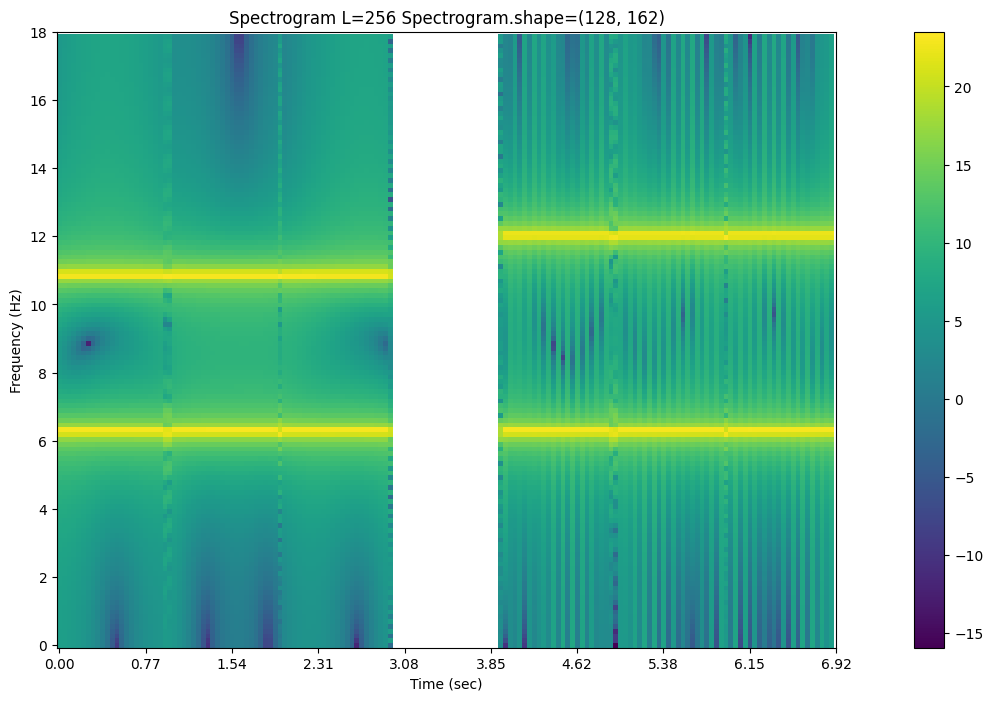

In [28]:
L = 256
noverlap = 84
mag = get_xns(ts)
Nxlim = 10
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(ts))
starts, spec = create_spectrogram(ts,L,noverlap = noverlap )
plot_spectrogram(spec,ks,sample_rate,L, starts)